## Demo PyHeat Val_direct

Ceci est une notebook de démo pour la récupération de valeur de température d'après la solution numérique des équations hydrothermiques.

In [29]:
from pyheatmy import *
import matplotlib.pyplot as plt
import numpy as np

## 0. Variables globales de l'expérience
Variables temporelles, nombre de cellules de colonne, paramètres de couche

In [30]:
# paremètres de l'expérience
t_debut = (2011, 8, 1)
t_fin = (2011, 8, 31, 23, 59, 59)
dt = 15*60 # pas de temps en (s)

T_riv_amp = 4
T_riv_offset = 20
P_T_riv = 7*24*4*dt

T_aq_amp = 0
T_aq_offset = 20
P_T_aq = 9999 # à mettre dans le init

dH_amp = 0
dH_offset = -1
P_dh = -9999 #14*24*4*dt

nb_cells = 100
depth_sensors = [.1, .2, .3, 1]
moinslog10K = 12
n = .1
lambda_s = 2
rho_cs = 4e6


## 1. Définition de l'expérience
Une fonction de définition de l'expérience a été codée dans le notebook cas test

In [31]:
# définition de l'expérience 

"""Times series"""
time_series_dict = {
    "offset" : 0,
    "depth_sensors":depth_sensors,
	"param_time_dates": [t_debut, t_fin, dt], 
    "param_dH_signal": [dH_amp, P_dh, dH_offset], #En vrai y aura une 4e valeur ici mais ca prendra en charge pareil
	"param_T_riv_signal": [T_riv_amp, P_T_riv, T_riv_offset],
    "param_T_aq_signal": [T_aq_amp, P_T_aq, T_aq_offset],
    "sigma_meas_P": 0.05,
    "sigma_meas_T": 0.1, #float
}
time_series = Time_series.from_dict(time_series_dict)
time_series._generate_perturb_T_riv_dH_series()
time_series._generate_perturb_Shaft_Temp_series()

"""Colonne"""
col_dict = {
	"river_bed": 1., 
    "depth_sensors": depth_sensors, #En vrai y aura une 4e valeur ici mais ca prendra en charge pareil
	"offset": .0,
    "dH_measures": time_series._T_riv_dH_measures,
    "T_measures": time_series._T_Shaft_measures,
    "sigma_meas_P": time_series._sigma_P, #float
    "sigma_meas_T": time_series._sigma_T, #float
}
colonne_exp = Column.from_dict(col_dict)

"""Layer"""
monolayer_dict = {
    "name": "sable",
    "zLow": depth_sensors[-1],
    "moinslog10K": moinslog10K,
    "n": n,
    "lambda_s": lambda_s,
    "rhos_cs": rho_cs
}
monolayer = Layer.from_dict(monolayer_dict)


"""Valeurs analytiques"""
analy_sol_dict = {
    "column_exp" : colonne_exp,
    "time_series" : time_series,
    "monolayer" : monolayer,
    "nb_cells" : nb_cells,
}

## 2. Démonstration de la fiabilité du modèle direct avec les solutions analytiques générales
L'utilisateur expert peut réaliser d'autres test en utilisant les objets générés.

### 2.1 Calcul du RMSE

In [32]:
analy_sol_exp = Analy_Sol.from_dict(analy_sol_dict)

# MAJ des attributs de l'objet
analy_sol_exp.compute_temp_general()
analy_sol_exp.compute_temp_cond()
analy_sol_exp.generate_RMSE_analytical(time_series, colonne_exp, monolayer)

--- Compute Solve Transi ---
One layer : moinslog10K = 12, n = 0.1, lambda_s = 2, rhos_cs = 4000000.0
Done.


array([0.00123811, 0.00315148, 0.00548253, 0.00372034])

### 2.2 Comparaison visuelle du modèle direct et de la solution analytique

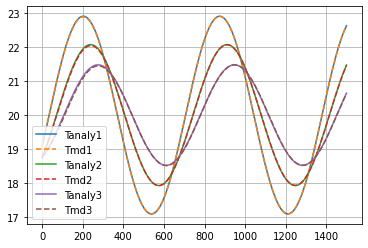

In [33]:
t_fin =1500

for i,id_sens in enumerate(analy_sol_exp._id_sensors) :
    plt.plot(analy_sol_exp.analy_temp_general[id_sens,:t_fin],label="Tanaly{}".format(i+1))
    plt.plot(time_series._T_Shaft[:t_fin,i],linestyle="--",label="Tmd{}".format(i+1))
plt.legend()
plt.grid()

### 2.3 Comparaison de la différence entre modèle direct et solution analytique en temporel

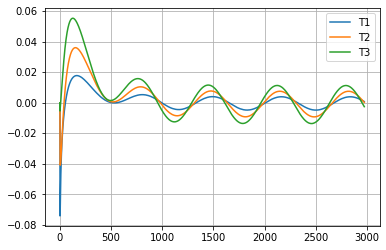

In [34]:
for i,id_sens in enumerate(analy_sol_exp._id_sensors) :
    plt.plot(analy_sol_exp.analy_temp_general[id_sens,:]-time_series._T_Shaft[:,i],label="T{}".format(i+1))
plt.legend()
plt.grid()

### 2.4 Comparaison du modèle direct et de la solution analytique en profil de température

Text(0, 0.5, 'z(m)')

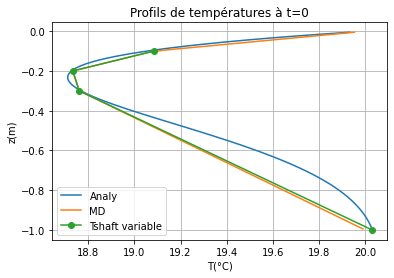

In [35]:
# l'utilisateur peut changer l'instant d'observation du profil
t_obs = 0

plt.plot(analy_sol_exp.analy_temp_cond[:,t_obs],-analy_sol_exp._z_solve, label='Analy')
plt.plot(colonne_exp.temps_solve[:,t_obs],-analy_sol_exp._z_solve, label='MD')
plt.plot(time_series._T_Shaft[t_obs],-np.array(colonne_exp.depth_sensors), marker='o',label='Tshaft variable')
plt.legend()
plt.grid()
plt.title("Profils de températures à t={}".format(t_obs))
plt.xlabel("T(°C)")
plt.ylabel("z(m)")

In [42]:
import matplotlib.animation as animation
from IPython import display

# initializing a figure
fig = plt.figure()
  
# labeling the x-axis and y-axis
axis = plt.axes(xlim=(15.5, 25),  ylim=(-1.05,0))
axis.grid()
axis.set_title("Profils de températures à t=0")
axis.set_xlabel("T(°C)")
axis.set_ylabel("z(m)")
line1, = axis.plot(0,0, label="analytical solution")
line2, = axis.plot(0,0,ls="--", label="direct model solution")
line3, = axis.plot(0,0,'o',ls="-." , label="sensors positions")
axis.legend()
fig.suptitle('Profils de températures', fontsize=14)

line1.set_ydata(-analy_sol_exp._z_solve)
line2.set_ydata(-analy_sol_exp._z_solve)
line3.set_ydata(-np.array(colonne_exp.depth_sensors))
def animate(frame_number):
    axis.set_title("Profils de températures à t={}".format(frame_number))
    line1.set_xdata(analy_sol_exp.analy_temp_cond[:,frame_number])
    line2.set_xdata(colonne_exp.temps_solve[:,frame_number])
    line3.set_xdata(time_series._T_Shaft[frame_number])
    return line1,line2,line3,

anim = animation.FuncAnimation(fig, animate, frames=1000, 
                               interval=200, blit=True)

# saving to m4 using ffmpeg writer
writervideo = animation.PillowWriter(fps=28)
anim.save('time_temp_profile.gif', writer=writervideo)
plt.close()

